# Basic analysis of naturally occurring mutations on IAV-NA
### To do: ehhhh.....

In [150]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss
from Bio import SeqIO
from Bio.Seq import Seq
import seaborn as sns
import matplotlib
from matplotlib import colors
from matplotlib import cm

In [30]:
seqdict = {}
infile = open('result/database/aligned_database_WSN_NA.fasta')
for record in SeqIO.parse(infile,'fasta'):
    seqdict[str(record.id)+str(record.description)] = str(record.seq)
infile.close()
print(len(seqdict))

19137


In [33]:
seqdict['WSN_NAWSN_NA']
refaa = refseq.replace('-','')
refaa

'MNPNQKIITIGSICMVVGIISLILQIGNIISIWISHSIQTGNQNHTGICNQGSITYKVVAGQDSTSVILTGNSSLCPIRGWAIHSKDNGIRIGSKGDVFVIREPFISCSHLECRTFFLTQGALLNDKHSRGTFKDRSPYRALMSCPVGEAPSPYNSRFESVAWSASACHDGMGWLTIGISGPDDGAVAVLKYNRIITETIKSWRKNILRTQESECTCVNGSCFTIMTDGPSDGLASYKIFKIEKGKVTKSIELNAPNSHYEECSCYPDTGKVMCVCRDNWHGSNRPWVSFDQNLDYKIGYICSGVFGDNPRPKDGTGSCGPVSADGANGVKGFSYKYGNGVWIGRTKSDSSRHGFEMIWDPNGWTETDSRFSMRQDVVAITNRSGYSGSFVQHPELTGLDCMRPCFWVELIRGLPEEDAIWTSGSIISFCGVNSDTVDWSWPDGAELPFTIDK'

Nice

In [4]:
fitdata = pd.read_csv('result/fitness.txt',sep='\t')
fitdata

,Pos,Genotype,Frame1,fitOS1,fitOS2,fitOS3,fitZA1,fitZA2,fitZA3,fitPE1,...,Frame1.1,fitOS1.1,fitOS2.1,fitOS3.1,fitZA1.1,fitZA2.1,fitZA3.1,fitPE1.1,fitPE2.1,fitPE3.1
0,1204,T1204C,L399P,0.030626,0.043833,0.037028,0.075175,0.065474,0.052905,0.065863,...,L399P,0.7500182788,1.073455644,0.9068099546,1.841016035,1.603443927,1.295617003,1.612967622,1.433837021,1.155776623
1,55,T55C,V16A,0.348370,0.030920,0.492686,0.403679,0.854423,0.210514,0.762032,...,V16A,0.6974685845,0.06190456811,0.9864013891,0.8082015472,1.710630092,0.4214668681,1.525655364,0.1705552086,0.05574482462
2,636,A636T,T210S,1.118677,0.487629,0.179738,0.009014,0.166664,0.059881,0.134891,...,T210S,8.182006881,3.566520288,1.314606092,0.06592978175,1.218981756,0.4379716565,0.9865917539,1.781947036,0.2284297527
3,636,A636G,T210A,2.692789,2.984731,6.495373,0.305717,4.752692,0.565581,0.861383,...,T210A,1.232999722,1.366677048,2.974162668,0.1399844213,2.176207777,0.2589736075,0.3944180069,0.767438128,0.5136201932
4,478,G478A,R157K,0.427213,0.373659,0.691260,0.381411,0.379574,0.627633,1.057682,...,R157K,0.4104276055,0.3589772924,0.6640996463,0.3664251602,0.3646602963,0.6029722805,1.016124561,0.5422460776,0.5037589337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,188,T188A,A60A,0.208072,0.000000,2.252380,0.844359,0.072851,4.826028,0.294676,...,A60A,0.1816755569,0,1.966639965,0.7372425402,0.06360938841,4.213790799,0.2572928888,0.1819411306,0.1616510763
2433,188,T188G,A60A,0.033508,0.000000,0.030749,0.152999,0.331434,0.321276,2.314088,...,A60A,0.01646664867,0,0.01511060573,0.07518656861,0.1628727359,0.1578809412,1.137185315,0,0.9061269907
2434,833,G833A,V275V,0.702368,4.999190,1.515895,0.169200,0.443830,3.044322,0.934089,...,V275V,0.486286422,3.461205277,1.049535043,0.1171463402,0.3072872418,2.107746248,0.6467193861,0.8898335433,0.9306368816
2435,833,G833C,V275V,0.016174,0.454540,0.351663,0.100933,0.055451,0.345588,0.027087,...,V275V,0.01034965906,0.2908579783,0.2250277011,0.06458657134,0.03548303435,0.2211399524,0.0173326486,2.952242269,0.4952976073


Let me see how good is fitness data

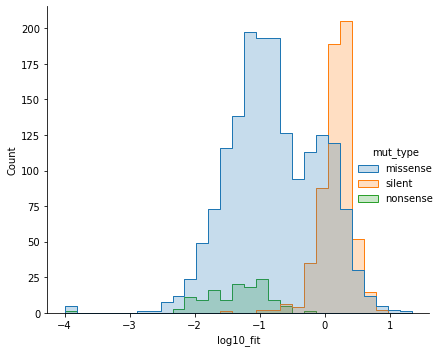

In [12]:
def find_muttype(mut):
    if mut[-1] == mut[0]:
        return 'silent'
    if mut[-1] == '_':
        return 'nonsense'
    return 'missense'

fitdata['mut_type'] = fitdata['Frame1'].apply(lambda x:find_muttype(x))
fitdata['log10_fit'] = np.log10(fitdata['MEANCTRL']+1e-4)
sns.displot(fitdata, x="log10_fit", hue="mut_type", element="step")
plt.tight_layout()

/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))
/home/Tianhao/Tools/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


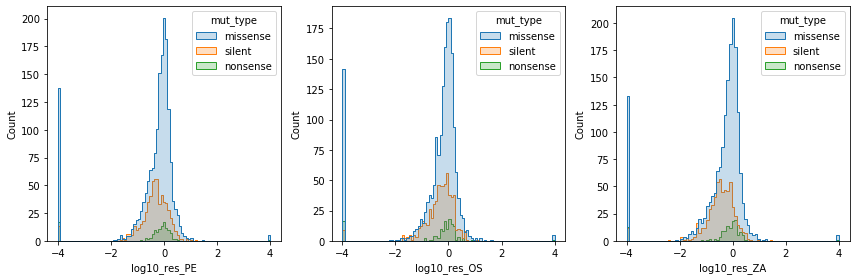

In [159]:
def res_mean(x,drug):
    meandrugfit = ss.gmean([x['fit'+drug+'1'],x['fit'+drug+'2'],x['fit'+drug+'2']])
    fit = x['MEANCTRL']
    if fit == 0:
        return 4
    else:
        return np.log10(meandrugfit/fit+1e-4)

druglist = ['PE','OS','ZA']
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    fitdata['log10_res_'+drug] = fitdata.apply(lambda x:res_mean(x,drug),axis=1)
    sns.histplot(fitdata, x='log10_res_'+drug, hue="mut_type", element="step",ax=ax)
plt.tight_layout()

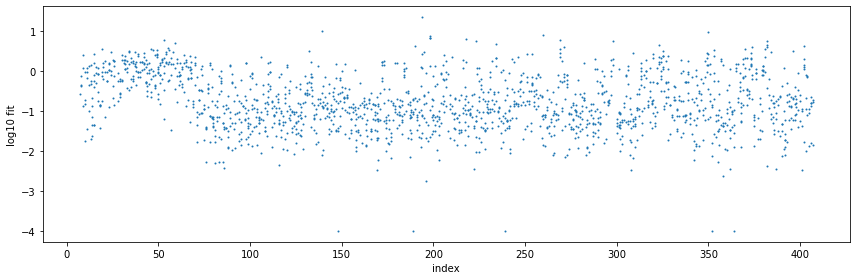

In [16]:
fitdata['aapos'] = fitdata['Frame1'].apply(lambda x:int(x[1:-1]))
plt.figure(figsize=(12,4))
plt.xlabel('index')
plt.ylabel('log10 fit')
plt.scatter(fitdata[fitdata['mut_type']=='missense']['aapos'],fitdata[fitdata['mut_type']=='missense']['log10_fit'],s=1)
plt.tight_layout()

Weird NTD

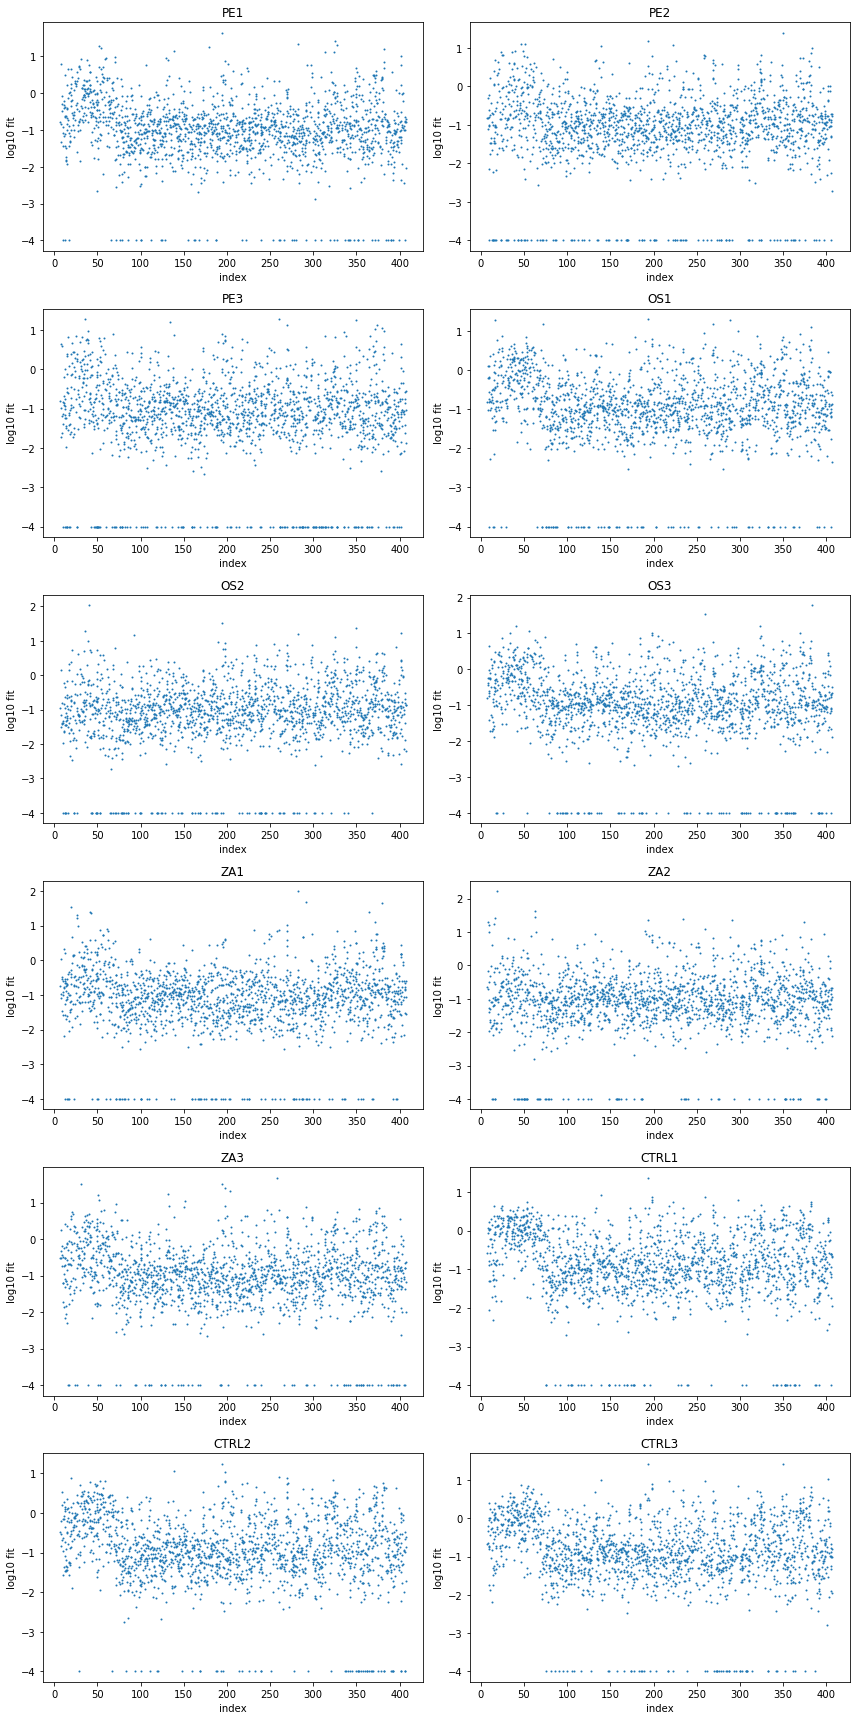

In [173]:
ploti = 0
plt.figure(figsize=(12,24))
for drug in druglist+['CTRL']:
    for rep in range(1,4):
        ploti += 1
        plt.subplot(6,2,ploti)
        plt.scatter(fitdata[fitdata['mut_type']=='missense']['aapos'],np.log10(fitdata[fitdata['mut_type']=='missense']['fit'+drug+str(rep)]+1e-4),s=1)
        plt.xlabel('index')
        plt.ylabel('log10 fit')
        plt.title(drug+str(rep))
plt.tight_layout()

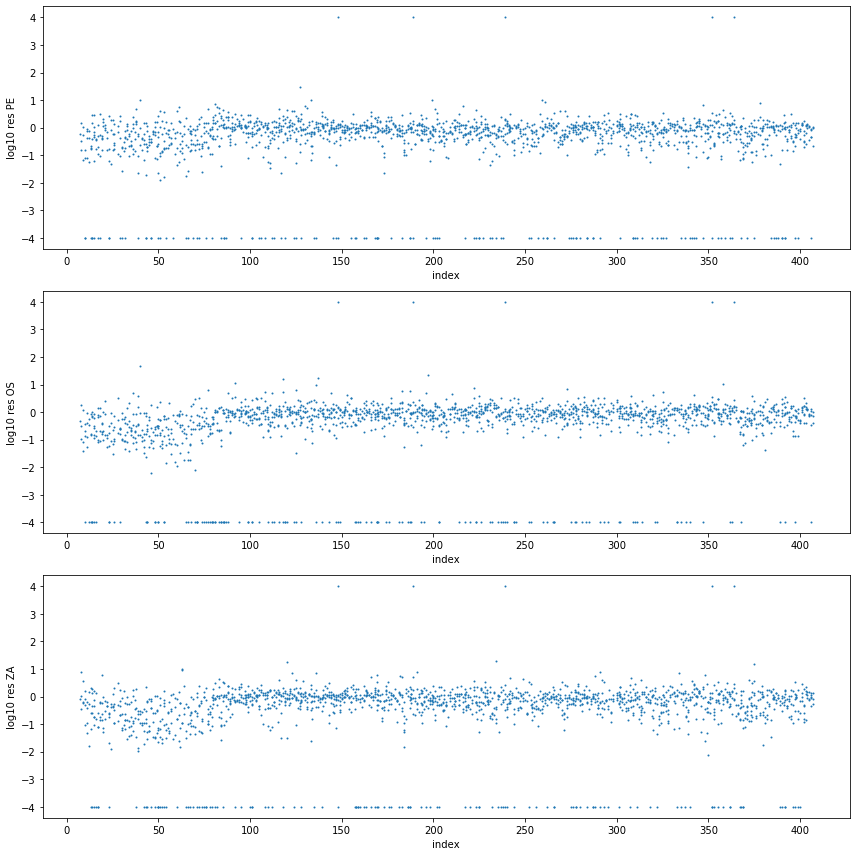

In [160]:
plt.figure(figsize=(12,12))
ploti = 0
for drug in druglist:
    ploti += 1
    plt.subplot(3,1,ploti)
    plt.xlabel('index')
    plt.ylabel('log10 res '+drug)
    plt.scatter(fitdata[fitdata['mut_type']=='missense']['aapos'],fitdata[fitdata['mut_type']=='missense']['log10_res_'+drug],s=1)
plt.tight_layout()

NTD is only a no drug problem. Maybe need to look into specific replicate.

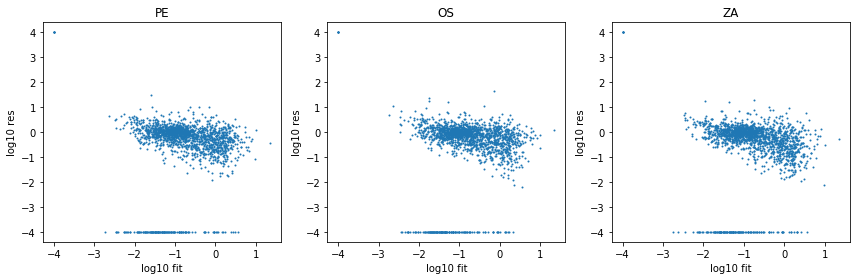

In [165]:
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    plt.subplot(1,3,ploti)
    plt.scatter(fitdata[fitdata['mut_type']=='missense']['log10_fit'],fitdata[fitdata['mut_type']=='missense']['log10_res_'+drug],s=1)
    plt.title(drug)
    plt.xlabel('log10 fit')
    plt.ylabel('log10 res')
plt.tight_layout()

Let's calculate fitness for all NOS

In [166]:
aaposlist = range(7,408)
aalist = list('RKDEHSTNQCGPAILMFWYV*')
smutlist = []; saaposlist = []; submutlist = []
for aapos in aaposlist:
    for aa in aalist:
        smutlist.append(refaa[aapos-1]+str(aapos)+aa)
        saaposlist.append(aapos)
        submutlist.append(aa)
sdata = pd.DataFrame(data={'mutation':smutlist,'aapos':saaposlist,'substituion':submutlist})
sdata

,mutation,aapos,substituion
0,I7R,7,R
1,I7K,7,K
2,I7D,7,D
3,I7E,7,E
4,I7H,7,H
...,...,...,...
8416,W407F,407,F
8417,W407W,407,W
8418,W407Y,407,Y
8419,W407V,407,V


In [167]:
def mean_me(mutation):
    tmpdata = fitdata[(fitdata['aapos']==int(mutation[1:-1]))]
    if mutation[0] == mutation[-1]:
        tmpdata = tmpdata[tmpdata['mut_type']=='silent']
    elif mutation[-1] == '*':
        tmpdata = tmpdata[tmpdata['mut_type']=='nonsense']
    else:
        tmpdata = tmpdata[tmpdata['Frame1']==mutation]
    if len(tmpdata) == 0:
        return 0
    else:
        return np.mean([x if x > -3 else -3 for x in list(tmpdata['log10_fit']) ])
    
sdata['mutational effect'] = sdata['mutation'].apply(lambda x:mean_me(x))
sdata 

,mutation,aapos,substituion,mutational effect
0,I7R,7,R,0.000000
1,I7K,7,K,0.000000
2,I7D,7,D,0.000000
3,I7E,7,E,0.000000
4,I7H,7,H,0.000000
...,...,...,...,...
8416,W407F,407,F,0.000000
8417,W407W,407,W,0.000000
8418,W407Y,407,Y,0.000000
8419,W407V,407,V,0.000000


In [168]:
def mean_res(mutation,drug):
    tmpdata = fitdata[(fitdata['aapos']==int(mutation[1:-1]))]
    if mutation[0] == mutation[-1]:
        tmpdata = tmpdata[tmpdata['mut_type']=='silent']
    elif mutation[-1] == '*':
        tmpdata = tmpdata[tmpdata['mut_type']=='nonsense']
    else:
        tmpdata = tmpdata[tmpdata['Frame1']==mutation]
    if len(tmpdata) == 0:
        return 0
    else:
        return np.mean([x if x > -4 else -4 for x in list(tmpdata['log10_res_'+drug]) ])

for drug in druglist:
    sdata['log10_'+drug+'_res'] = sdata['mutation'].apply(lambda x:mean_res(x,drug))
    #sdata = sdata[sdata['mutational effect']!=0]
sdata 

,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res
0,I7R,7,R,0.000000,0.000000,0.000000,0.000000
1,I7K,7,K,0.000000,0.000000,0.000000,0.000000
2,I7D,7,D,0.000000,0.000000,0.000000,0.000000
3,I7E,7,E,0.000000,0.000000,0.000000,0.000000
4,I7H,7,H,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
8416,W407F,407,F,0.000000,0.000000,0.000000,0.000000
8417,W407W,407,W,0.000000,0.000000,0.000000,0.000000
8418,W407Y,407,Y,0.000000,0.000000,0.000000,0.000000
8419,W407V,407,V,0.000000,0.000000,0.000000,0.000000


In [169]:
datelist = []
inferfitlist = []
seqlist = []
nmutlist = []
reslist = {}
for drug in druglist:
    reslist[drug] = []
count = 0
for seqname in seqdict:
    if count % 1000 == 0:
        print('reading reference count: '+str(count)+'\nDated sequence: '+str(len(datelist)))
    count += 1
    seq = seqdict[seqname]
    aaseq = ''
    for i,aa in enumerate(seq):
        if refseq[i] == '-': continue
        else:
            aaseq += aa
    if len(refaa) != len(aaseq): 
        continue
    try:
        date = int(seqname.rsplit('Strain Name:')[-1].rsplit('|')[0].rsplit('(')[0][-4:])
    except:
        print(seqname)
        continue
    if date < 2009: continue
    datelist.append(date)
    fit = 0
    nmut = 0
    pe = 0
    za = 0
    os = 0
    for i in range(len(refaa)):
        if refaa[i] != aaseq[i]:
            nmut += 1
            qmut = refaa[i]+str(i+1)+aaseq[i]
            sfit = sdata[sdata['mutation']==qmut]['mutational effect']
            if len(sfit) == 0:
                continue
            fit += sum(sfit)
            pe += sum(sdata[sdata['mutation']==qmut]['log10_PE_res'])
            za += sum(sdata[sdata['mutation']==qmut]['log10_ZA_res'])
            os += sum(sdata[sdata['mutation']==qmut]['log10_OS_res'])
    inferfitlist.append(fit)
    seqlist.append(aaseq)
    nmutlist.append(nmut)
    reslist['PE'].append(pe)
    reslist['ZA'].append(za)
    reslist['OS'].append(os)
print('all sequences: '+str(len(datelist)))
print('unknown mutations: '+str(len(unknownmut)))
naturedata = pd.DataFrame(list(zip(seqlist, inferfitlist, datelist, nmutlist,reslist['PE'],reslist['ZA'],reslist['OS'])), 
               columns =['sequence', 'infered fitness', 'date', 'n.mut','PE_res','ZA_res','OS_res']) 

reading reference count: 0
Dated sequence: 0
reading reference count: 1000
Dated sequence: 1000
reading reference count: 2000
Dated sequence: 2000
WSN_NAWSN_NA
reading reference count: 3000
Dated sequence: 2999
reading reference count: 4000
Dated sequence: 3999
reading reference count: 5000
Dated sequence: 4999
reading reference count: 6000
Dated sequence: 5999
reading reference count: 7000
Dated sequence: 6999
reading reference count: 8000
Dated sequence: 7999
reading reference count: 9000
Dated sequence: 8999
reading reference count: 10000
Dated sequence: 9999
reading reference count: 11000
Dated sequence: 10999
reading reference count: 12000
Dated sequence: 11999
reading reference count: 13000
Dated sequence: 12999
reading reference count: 14000
Dated sequence: 13999
reading reference count: 15000
Dated sequence: 14999
gb:MT423010|ncbiId:QJP03039.1|UniProtKB:-N/A-|Organism:Influenzagb:MT423010|ncbiId:QJP03039.1|UniProtKB:-N/A-|Organism:Influenza A virus|Strain Name:A/USA/LAN_|Protei

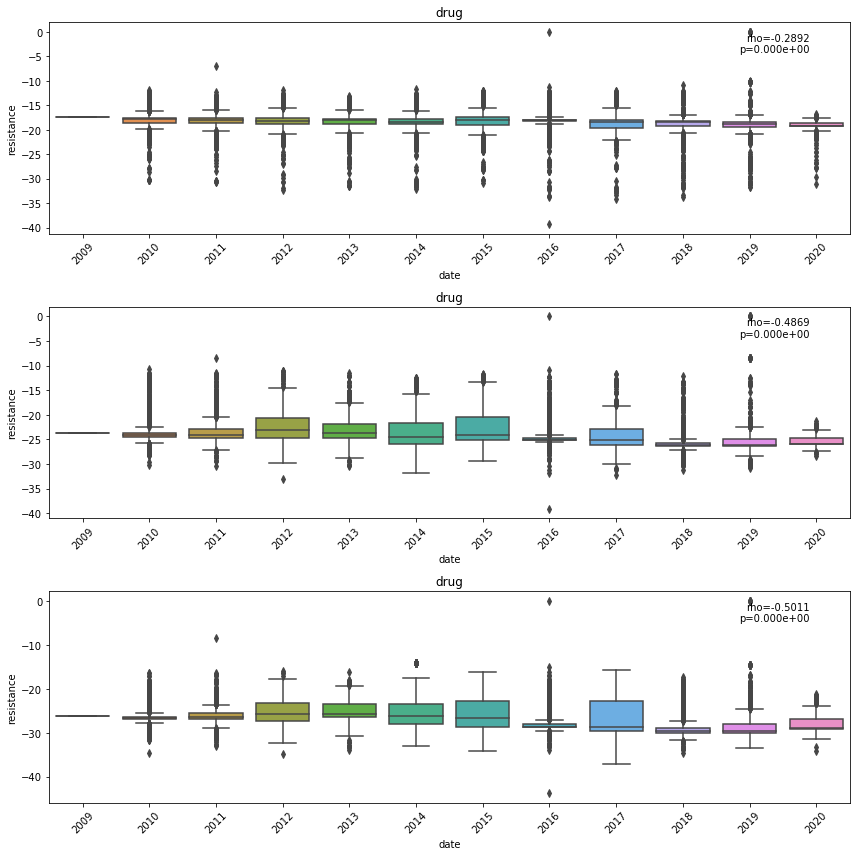

In [170]:
naturedata = naturedata.sort_values(by='date',ascending=True)
plt.figure(figsize=(12,12))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(3,1,ploti)
    #ax.scatter(naturedata['date'],naturedata['n.mut'],edgecolor='black',alpha=0.5)
    sns.boxplot(data=naturedata,x='date',y=drug+'_res',ax=ax)
    #plt.plot(naturedata['date'],naturedata['localnmut'],lw=4)
    plt.xticks(rotation=45)
    plt.ylabel('resistance')
    plt.title('drug')
    #plt.ylim([50,100])
    r,p = ss.spearmanr(naturedata['date'],naturedata[drug+'_res'])
    plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('time_res.png',dpi=600)

In [87]:
localnmut = []
window = 100
naturedata = naturedata.sort_values(by='date',ascending=True)
for i in range(window):
    localnmut.append(np.mean(naturedata['n.mut'][:i+1]))
for i in range(len(naturedata)-window):
    localnmut.append(np.mean(naturedata['n.mut'][i:i+window]))
naturedata['localnmut'] = localnmut

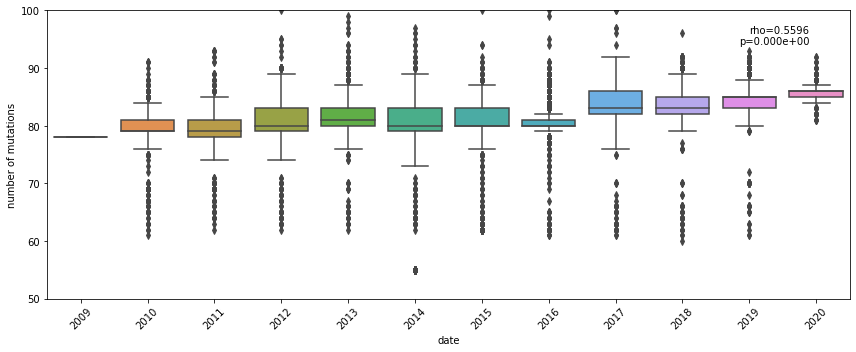

In [88]:
plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
#ax.scatter(naturedata['date'],naturedata['n.mut'],edgecolor='black',alpha=0.5)
sns.boxplot(data=naturedata,x='date',y='n.mut')
#plt.plot(naturedata['date'],naturedata['localnmut'],lw=4)
plt.xticks(rotation=45)
plt.ylabel('number of mutations')
plt.ylim([50,100])
r,p = ss.spearmanr(naturedata['date'],naturedata['n.mut'])
plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('time_mut_number.png',dpi=600)

In [89]:
localmean = []
window = 1000
for i in range(window):
    localmean.append(np.mean(naturedata['infered fitness'][:i+1]))
for i in range(len(naturedata)-window):
    localmean.append(np.mean(naturedata['infered fitness'][i:i+window]))
naturedata['localmean'] = localmean
naturedata = naturedata[-naturedata['infered fitness'].isnull()]

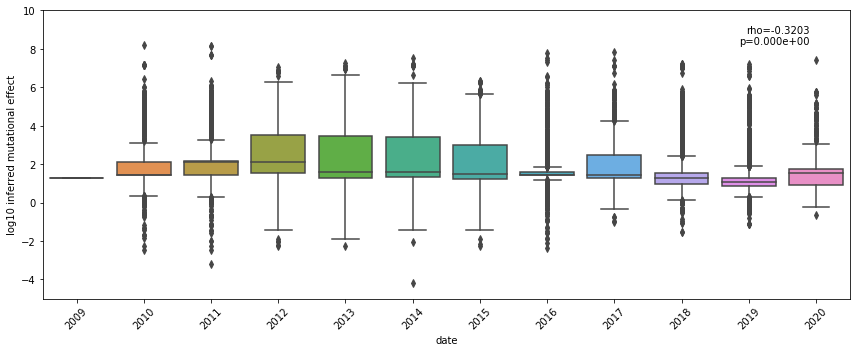

In [94]:
plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
#ax.scatter(naturedata['date'],naturedata['infered fitness'],edgecolor='black',alpha=0.01)
sns.boxplot(data=naturedata,x='date',y='infered fitness')
#plt.plot(naturedata['date'][window:],naturedata['localmean'][window:],lw=4,c='orange')
plt.xticks(rotation=45)
plt.ylabel('log10 inferred mutational effect')
plt.ylim([-5,10])
r,p = ss.spearmanr(naturedata['date'],naturedata['infered fitness'])
plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('time_fitness.png',dpi=600)

In [176]:
def find_mut(x):
    muts = []
    for i in range(len(refaa)):
        if refaa[i]!=x[i]: muts.append(str(refaa[i])+str(i+1)+str(x[i]))
    return '_'.join(muts)

def find_occurence(mut):
    tmpdata = naturedata[naturedata['muts'].str.contains(mut,regex=False)]
    return len(tmpdata)/len(naturedata)

def find_muttype(mut):
    if mut[-1] == mut[0]:
        return 'silent'
    if mut[-1] == '*':
        return 'nonsense'
    return 'missense'

sdata['mut_type'] = sdata['mutation'].apply(lambda x:find_muttype(x))
naturedata['muts'] = naturedata['sequence'].apply(lambda x:find_mut(x))
sdata['occurence'] = sdata['mutation'].apply(lambda x:find_occurence(x))

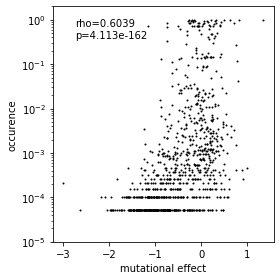

In [112]:
plt.figure(figsize=(4,4))
ax = plt.subplot(111)
plt.scatter(sdata[sdata['mut_type']=='missense']['mutational effect'],sdata[sdata['mut_type']=='missense']['occurence'],edgecolor='black',s=1)
plt.xlabel('mutational effect')
plt.ylabel('occurence')
plt.yscale('log')
#plt.plot([1,1],[1e-6,1e0],linestyle='--',lw=2,color='grey')
plt.ylim([1e-5,2e0])
r,p = ss.spearmanr(sdata[sdata['mut_type']=='missense']['mutational effect'],sdata[sdata['mut_type']=='missense']['occurence'])
plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('natural_occurence_fitness.png',dpi=600)

In [178]:
tsdata = sdata[sdata['mutational effect']!=0]
tsdata

,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res,mut_type,occurence
15,I7M,7,M,-0.572072,-0.235909,-0.331491,-0.099242,missense,0.001046
27,I8T,8,T,-0.122301,0.173310,0.245850,0.025175,missense,0.001516
34,I8I,8,I,0.016476,-1.128633,-0.005229,-1.347374,silent,0.000000
36,I8M,8,M,-0.349772,-0.483525,-0.501023,0.886235,missense,0.010979
40,I8V,8,V,-0.374438,-0.802052,-0.965094,-0.469617,missense,0.029486
...,...,...,...,...,...,...,...,...,...
8395,F406F,406,F,0.484664,-0.897986,-0.122295,-0.751005,silent,0.000000
8397,F406Y,406,Y,-0.807176,-0.340906,-0.466292,-0.339326,missense,0.000000
8400,W407R,407,R,-1.321047,-0.313143,-0.197991,0.025427,missense,0.000052
8414,W407L,407,L,-0.717934,-0.028875,-0.152623,-0.261345,missense,0.000000


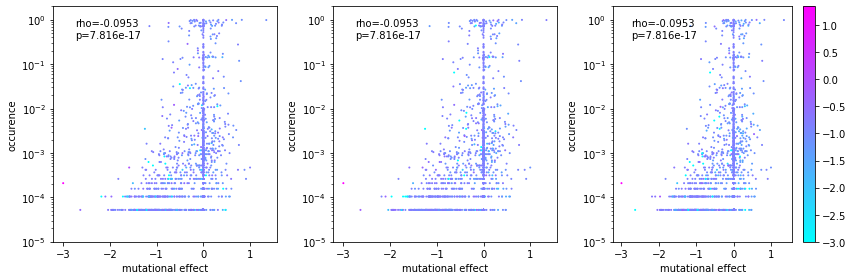

In [185]:
#color by res
cmap = matplotlib.cm.get_cmap('cool')

def res2col(x):
    mincol = min(tsdata['log10_'+drug+'_res'])
    maxcol = max(tsdata['log10_'+drug+'_res'])
    color=(x-mincol)/(maxcol-mincol)
    return cmap(color)

plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    tsdata[drug+'_color']=tsdata['log10_'+drug+'_res'].apply(lambda x:res2col(x))
    plt.scatter(tsdata[tsdata['mut_type']=='missense']['mutational effect'],tsdata[tsdata['mut_type']=='missense']['occurence'],color=tsdata[tsdata['mut_type']=='missense'][drug+'_color'],s=1)
    plt.xlabel('mutational effect')
    plt.ylabel('occurence')
    plt.yscale('log')
    plt.ylim([1e-5,2e0])
    r,p = ss.spearmanr(tsdata[tsdata['mut_type']=='missense']['mutational effect'],tsdata[tsdata['mut_type']=='missense']['occurence'])
    plt.text(0.10,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='left',va='top',transform=ax.transAxes)
    plt.title('color by '+drug+' res')
plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=mincol, vmax=maxcol), cmap=cmap))
plt.tight_layout()
plt.savefig('natural_occurence_fitness_res.png',dpi=600)

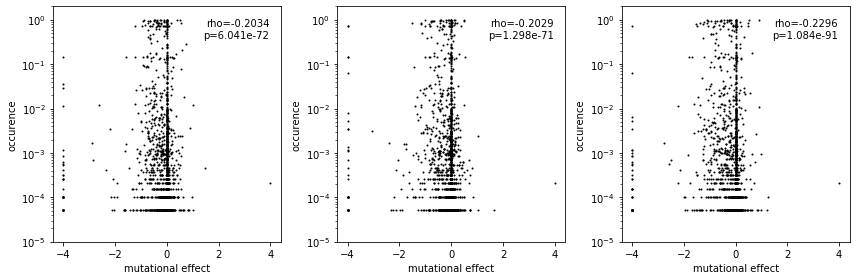

In [182]:
plt.figure(figsize=(12,4))
ploti = 0
for drug in druglist:
    ploti += 1
    ax = plt.subplot(1,3,ploti)
    plt.scatter(sdata[sdata['mut_type']=='missense']['log10_'+drug+'_res'],sdata[sdata['mut_type']=='missense']['occurence'],edgecolor='black',s=1)
    plt.xlabel('mutational effect')
    plt.ylabel('occurence')
    plt.yscale('log')
    #plt.plot([1,1],[1e-6,1e0],linestyle='--',lw=2,color='grey')
    plt.ylim([1e-5,2e0])
    r,p = ss.spearmanr(sdata[sdata['mut_type']=='missense']['log10_'+drug+'_res'],sdata[sdata['mut_type']=='missense']['occurence'])
    plt.text(0.95,0.95,'rho='+str(round(r,4))+'\np='+'{:.3e}'.format(p),ha='right',va='top',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('natural_occurence_resistance.png',dpi=600)

bad thing is WSN is very different from circulating strains.
good thing is mut frequency correlate with fitness well.

## Per year occurence

In [114]:
def find_occurence(mut):
    tmpdata = naturedata[naturedata['date']==year]
    tmpdata1 = tmpdata[tmpdata['muts'].str.contains(mut,regex=False)]
    return len(tmpdata1)/len(tmpdata)

for year in range(2010,2021):
    sdata['occurence_'+str(year)] = sdata['mutation'].apply(lambda x:find_occurence(x))

In [133]:
def judge_change(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)])
    if min(freqlist) < 0.05 and max(freqlist) > 0.5:
        return True
    return False

sdata['changed_mut'] = sdata.apply(lambda x:judge_change(x),axis=1)
cdata = sdata[sdata['changed_mut']]

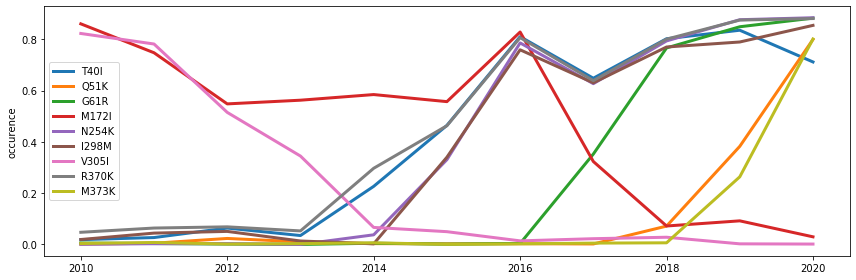

In [139]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)])
    datelist = range(2010,2021)
    plt.plot(datelist,freqlist,label=x['mutation'],lw=3)
    
plt.figure(figsize=(12,4))
cdata.apply(lambda x:draw_line(x),axis=1)
plt.legend()
plt.ylabel('occurence')
plt.tight_layout()

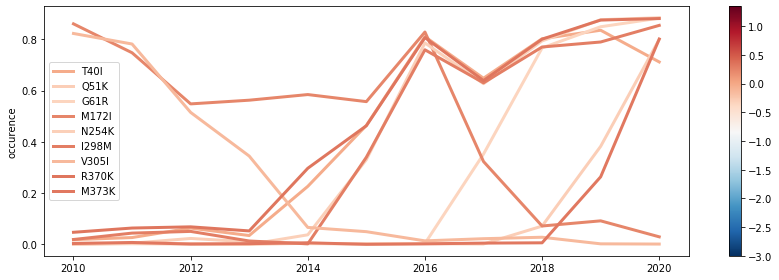

In [152]:
def draw_line(x):
    freqlist = []
    for year in range(2010,2021):
        freqlist.append(x['occurence_'+str(year)])
    datelist = range(2010,2021)
    color=(x['mutational effect']-mincol)/(maxcol-mincol)
    plt.plot(datelist,freqlist,label=x['mutation'],lw=3,c=cmap(color))

cmap = matplotlib.cm.get_cmap('RdBu_r')
mincol = min(sdata['mutational effect'])
maxcol = max(sdata['mutational effect'])
plt.figure(figsize=(12,4))
cdata.apply(lambda x:draw_line(x),axis=1)
plt.legend()
plt.ylabel('occurence')
plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=mincol, vmax=maxcol), cmap=cmap))
plt.tight_layout()

In [175]:
sdata

,mutation,aapos,substituion,mutational effect,log10_PE_res,log10_OS_res,log10_ZA_res
0,I7R,7,R,0.000000,0.000000,0.000000,0.000000
1,I7K,7,K,0.000000,0.000000,0.000000,0.000000
2,I7D,7,D,0.000000,0.000000,0.000000,0.000000
3,I7E,7,E,0.000000,0.000000,0.000000,0.000000
4,I7H,7,H,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
8416,W407F,407,F,0.000000,0.000000,0.000000,0.000000
8417,W407W,407,W,0.000000,0.000000,0.000000,0.000000
8418,W407Y,407,Y,0.000000,0.000000,0.000000,0.000000
8419,W407V,407,V,0.000000,0.000000,0.000000,0.000000
